Проанализировать данные по выживаемости. Обучить модель предсказания выживет ли человек или нет (ключевая переменная) (различные варианты визуализации можно посмотреть здесь https://www.kaggle.com/competitions/titanic/code?competitionId=3136&sortBy=scoreDescending&language=Python).
Определить наиболее значимые переменные которые влияют на выживаемость. 
Визуализировать дерево решений. 
Написать вывод. 
Не копировать бездумно чужие работы. 


Ответить на вопросы (обоснованно).

1. Как влияет размер семьи  на вероятность виживаемости (одинокие выживают чаще или нет?, люди у которых большая семья (больше 4) выживают чаще или нет).
2. Как влияет пол/возраст/номер палубы. 

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import sqlite3
import statistics 

from collections import Counter
import math

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree

titanic_train = pd.read_csv("titanic_train.csv")
titanic_train = titanic_train.set_index('PassengerId')
titanic_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 891 entries, 1 to 891
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  891 non-null    int64  
 1   Pclass    891 non-null    int64  
 2   Name      891 non-null    object 
 3   Sex       891 non-null    object 
 4   Age       714 non-null    float64
 5   SibSp     891 non-null    int64  
 6   Parch     891 non-null    int64  
 7   Ticket    891 non-null    object 
 8   Fare      891 non-null    float64
 9   Cabin     204 non-null    object 
 10  Embarked  889 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 83.5+ KB


## Для начала обработаем пропуски

In [2]:
#проверим пропуски по NaN
for col in titanic_train.columns:
    pct_missing = np.mean(titanic_train[col].isnull())
    print('{} - {}%'.format(col, round(pct_missing*100)))
#исходя из этого выборки есть пропуски Age и Cabin

Survived - 0%
Pclass - 0%
Name - 0%
Sex - 0%
Age - 20%
SibSp - 0%
Parch - 0%
Ticket - 0%
Fare - 0%
Cabin - 77%
Embarked - 0%


In [3]:
#проверим пропуски нулям
for col in titanic_train.columns:
    pct_missing = np.mean(titanic_train[col] == 0)
    print('{} - {}%'.format(col, round(pct_missing*100)))
#Некорректным в данном случае будем считать данные по Fare

Survived - 62%
Pclass - 0%
Name - 0%
Sex - 0%
Age - 0%
SibSp - 68%
Parch - 76%
Ticket - 0%
Fare - 2%
Cabin - 0%
Embarked - 0%


In [4]:
#заполним пропуски в с столбце Age

df = titanic_train.copy(deep = True)

df.Age = df.Age.fillna(df.groupby(['Pclass','Sex'])['Age'].transform('median'))

#Заполним пропуски с столбце Fare
df.loc[df.Fare==0, 'Fare'] = np.nan
df.Fare = df.Fare.fillna(df.groupby(['Pclass','Sex'])['Fare'].transform('median'))

In [5]:
df.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


Соотнесем пассажиров с палубой. Для этого возьмем первую букву в данных по кабине. Для пропусков обработка будет происходить следующим образом: поскольку данные в столбце Ticket повторяются, часть пропусков заполним на основании повтора билетов. Для этого создадим словарь соответствия палубы и билета

In [6]:
df_cleaned_cabin = df[df["Cabin"].notnull()]

ticket_deck = dict() #словарь, хранящий соотношение билета и палубы

ticket_counter = 0

for ticket in df_cleaned_cabin["Ticket"]:
    if ticket not in ticket_deck:
        cabin = df_cleaned_cabin.iloc[ticket_counter]['Cabin']
        ticket_deck[ticket] = cabin[0]
    ticket_counter+=1
    

#### Вытаскиваем у имеющихся первую букву каюты, остальные меняем на unkn - неизвестные. Создаем переменную Deck (палуба)
df.Cabin.fillna('no', inplace=True)
df.loc[df.Cabin.str.contains('A'),'Deck']='A'
df.loc[df.Cabin.str.contains('B'),'Deck']='B'
df.loc[df.Cabin.str.contains('C'),'Deck']='C'
df.loc[df.Cabin.str.contains('D'),'Deck']='D'
df.loc[df.Cabin.str.contains('E'),'Deck']='E'
df.loc[df.Cabin.str.contains('F'),'Deck']='F'
df.loc[df.Cabin.str.contains('G'),'Deck']='G'
df.loc[df.Cabin.str.contains('T'),'Deck']='T'
df.loc[df.Cabin=='no', 'Deck']='unknown'

#заполянем пустое значению
for ticket in ticket_deck.keys():
    df.loc[(df.Ticket.str.contains(ticket)) & (df.Cabin.str.contains('unknown')),'Deck']=ticket_deck[ticket]
    
df.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Deck
PassengerId,,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,no,S,unknown
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,C
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,no,S,unknown
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,C
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,no,S,unknown


In [7]:
#Для остальных палуб будем опираться на значение диапазона накоплений. Для работы с данными напрямую воспользуемся sql

import sqlite3
con = sqlite3.connect('db_titanic')

def select(sql):
  return pd.read_sql(sql,con)


df_cleaned_cabin.loc[df.Cabin.str.contains('A'),'Deck']='A'
df_cleaned_cabin.loc[df.Cabin.str.contains('B'),'Deck']='B'
df_cleaned_cabin.loc[df.Cabin.str.contains('C'),'Deck']='C'
df_cleaned_cabin.loc[df.Cabin.str.contains('D'),'Deck']='D'
df_cleaned_cabin.loc[df.Cabin.str.contains('E'),'Deck']='E'
df_cleaned_cabin.loc[df.Cabin.str.contains('F'),'Deck']='F'
df_cleaned_cabin.loc[df.Cabin.str.contains('G'),'Deck']='G'
df_cleaned_cabin.loc[df.Cabin.str.contains('T'),'Deck']='T'


df_cleaned_cabin.to_sql('titanic_train', con, index=False, if_exists='replace')

D:\Olya_work\anaconda3\lib\site-packages\pandas\core\indexing.py:1684: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = infer_fill_value(value)
D:\Olya_work\anaconda3\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


In [8]:
sql = ''' SELECT deck, MAX(Fare) AS MAX_F FROM titanic_train AS t
GROUP by deck '''

select(sql)

,Deck,MAX_F
0,A,81.8583
1,B,512.3292
2,C,263.0000
3,D,113.2750
4,E,134.5000
5,F,39.0000
6,G,16.7000
7,T,35.5000


Таким образхом делаем вывод, что в зависимости от палубы у нас следующий диапазон цен: 
- Палуба G 16.7000 и меньше
- Палуба F от 16.7000 до 39.0000
- Палуба A от 39.0000 до 81.8583
- Палуба D от 81.8583 до 113.2750
- Палуба E от 113.2750 до 134.5000
- Палуба C от 113.2750 до 263.0000
- Палуба B от 263.0000 до 512.3292

Заполним в соответстивии с этим диапазоном оставшиеся пропуски

In [9]:
df.loc[((df.Deck.str.contains('unknown')) & (df["Fare"] <= 16.7000),'Deck')] = 'G'
df.loc[((df.Deck.str.contains('unknown')) & (df["Fare"] <= 39.0000),'Deck')] = 'F'
df.loc[((df.Deck.str.contains('unknown')) & (df["Fare"] <= 81.8583),'Deck')] = 'A'
df.loc[((df.Deck.str.contains('unknown')) & (df["Fare"] <= 113.2750),'Deck')] = 'D'
df.loc[((df.Deck.str.contains('unknown')) & (df["Fare"]<= 134.5000),'Deck')] = 'E'
df.loc[((df.Deck.str.contains('unknown')) & (df["Fare"] <= 263.0000),'Deck')] = 'C'
df.loc[((df.Deck.str.contains('unknown')) & (df["Fare"] <= 512.3292),'Deck')] = 'B'

df.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Deck
PassengerId,,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,no,S,G
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,C
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,no,S,G
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,C
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,no,S,G


In [10]:
#добавляем столбец с количеством члнов семьи:
df['FamilySize'] = df.SibSp+df.Parch+1

df.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Deck,FamilySize
PassengerId,,,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,no,S,G,2
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,C,2
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,no,S,G,1
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,C,2
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,no,S,G,1


Теперь заполнены все категориальные значения: данные о палубе, о месте назначения о классе и выживаемости у нас есть такие столбцы как имя, билет, цена билета и кабина уже не нужны, удалим их. 

In [11]:
df = df.drop(columns = ['Name', 'Ticket', 'Fare', 'Cabin', 'SibSp', 'Parch'], axis = 1)
df.head()

,Survived,Pclass,Sex,Age,Embarked,Deck,FamilySize
PassengerId,,,,,,,
1,0,3,male,22.0,S,G,2
2,1,1,female,38.0,C,C,2
3,1,3,female,26.0,S,G,1
4,1,1,female,35.0,S,C,2
5,0,3,male,35.0,S,G,1


Теперь численные и категориальные признаки, закодируем их

In [12]:
df = pd.concat ([df,
                pd.get_dummies (df.Sex, prefix = 'Sex'),
                pd.get_dummies (df.Embarked, prefix = 'Embarked'),
                pd.get_dummies (df.Deck, prefix = 'Deck')], axis=1)

df.drop (['Embarked', 'Sex', 'Deck'], axis = 1, inplace=True)

In [13]:
y=df.Survived.astype(int)

X=df.drop(['Survived'], axis=1)
X['Age'] = df['Age'].astype('float32')

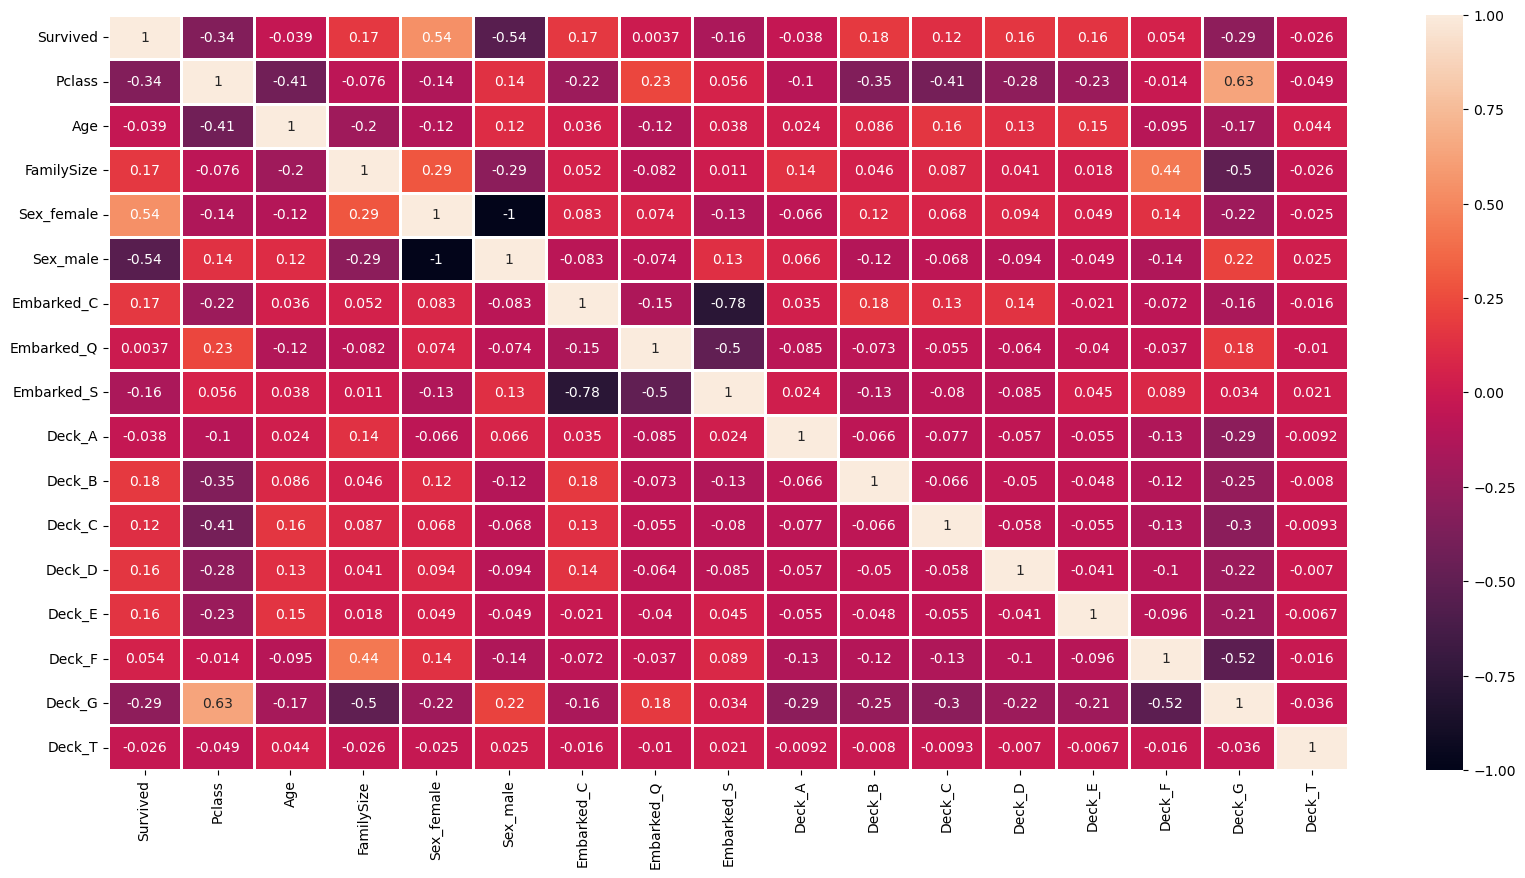

In [14]:
plt.figure(figsize=(20,10), dpi=100)
corr = df.corr(method='spearman')
sns.heatmap(corr, annot=True, linewidths=1);

Исходя из матрицы корреляции видим следующие зависимости: 
1) Большая корреляция выживаемости с полом пассажиров(у женщин шансов выжить было больше)

2) Отрицательная корреляция с классом и возрастом(чем старше пассажир и чем меньшим классом он едет, тем меньше шансов выжить)

3) Есть некоторая зависимость от количества детей в семье(люди с семьями чуть чаще выживали) и номера палубы(больше выживало людей с палуб B, D и E)

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X,y,random_state=42, train_size=0.2)

In [16]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV

clf = DecisionTreeClassifier()
clf.fit(X_train, y_train)

DecisionTreeClassifier()

In [17]:
params = {'max_depth': range (2, 21, 1)}

clf_gridsearch = GridSearchCV(DecisionTreeClassifier(random_state=42), param_grid=params, n_jobs=-1, cv=5, verbose=5)
clf_gridsearch.fit(X_train,y_train)

print('Best Parameters : {}'.format(clf_gridsearch.best_params_))
print('Best Accuracy Through Grid Search : {:.3f}\n'.format(clf_gridsearch.best_score_))
print('AUC на обучающей выборке: {:.3f}'.
    format(accuracy_score(y_train, clf_gridsearch.predict(X_train))))

Fitting 5 folds for each of 19 candidates, totalling 95 fits
Best Parameters : {'max_depth': 3}
Best Accuracy Through Grid Search : 0.810

AUC на обучающей выборке: 0.860


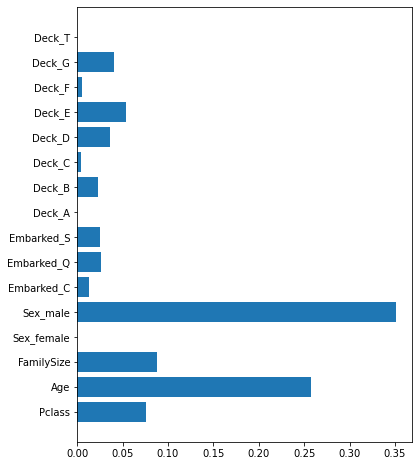

In [18]:
plt.figure(figsize=(6,8))
plt.barh(np.arange(len(clf .feature_importances_)), clf .feature_importances_)
plt.yticks(np.arange(len(X_train.columns)),X_train.columns);

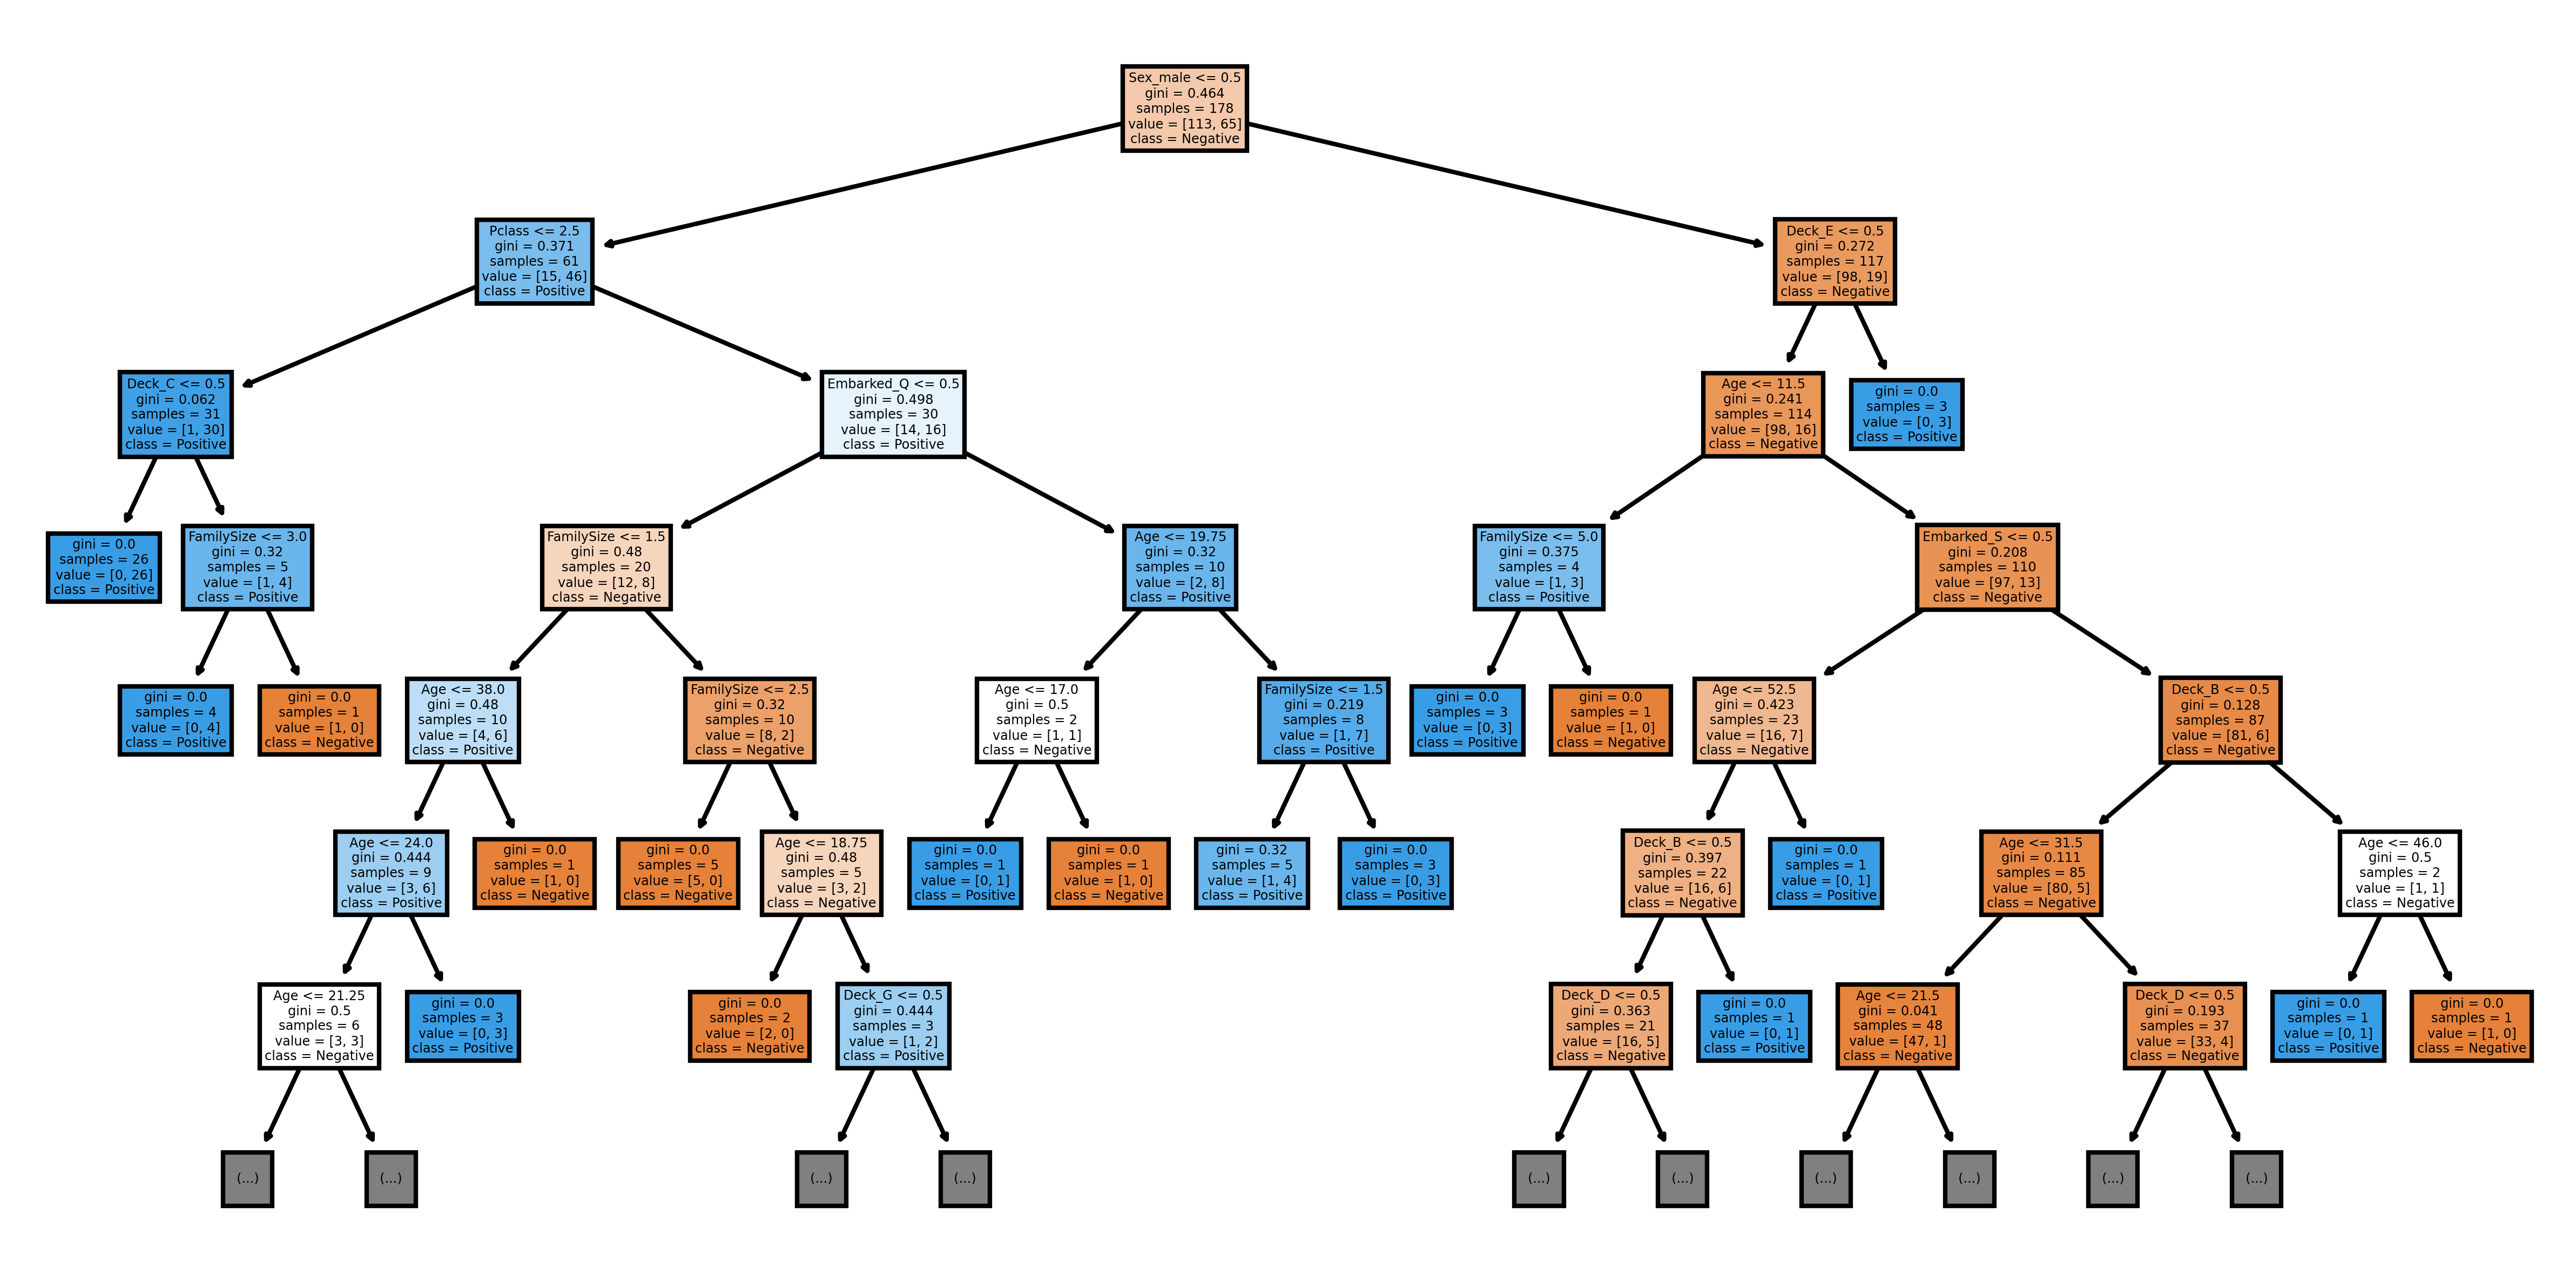

In [19]:
fig, axes = plt.subplots(nrows = 1,ncols = 1,figsize = (10,5), dpi=600)
tree.plot_tree(clf, feature_names=list(X_train),max_depth=6,
               class_names = ['Negative','Positive'],
               filled = True);

Выводы: 

Как влияет размер семьи на вероятность виживаемости (одинокие выживают чаще или нет?, люди у которых большая семья (больше 4) выживают чаще или нет).
Как влияет пол/возраст/номер палубы.

1) Было постороено дерево принятия решений на основанни данных о выживаемости корабля.
2) Исходя из данных о цены билета, номера кабины и номера билета были определены палубы для каждого из пассажиров. 
Так же были установлены следующие зависимости: 
- Основными критериями выживамаемости пассажиров стали номер пол и возраст(у женщин и детей было больше шансов спастись), класс(больше людей, ехавших более престижным классами выжило), которым ехал пассажир, его палуба(а имеено B, D и E) 
- более высокими классами ехали люди более старшего возраста, они же обычно и имели меньший размер семей